In [1]:
import os, sys

In [2]:
import sympy as sym

In [3]:
from sympy.stats import E, variance, Normal

In [4]:
from copy import deepcopy

In [5]:
sys.path.insert(0, os.path.abspath('../../src/'))

In [6]:
from numerical.symbolics import LagrangePolynomial

In [7]:
# Help make the out easier to read.
sym.init_printing(use_unicode=True)

## Double-Well equations

For this system we just need to make the following replacements ...

In [ ]:
# Double well drift function f(x).
# 
# D = 1
# 
# fx = sym.Matrix((4 * xt) * (p - xt**2), real=True); fx
# 
# p = sym.Matrix([sym.symbols("theta", real=True)])
# 

## Lorenz - 3D equations

### First define the main variables.

In [8]:
# Systems dimensions.
D = 3

# Mean and variance functions: m(t), s(t).
mt = sym.symbols(f"m:{D+1}(t)", real=True)
st = sym.symbols(f"s:{D+1}(t)", real=True, positive=True)

# Random (state) vector: x(t).
xt = sym.Matrix([Normal(f"x{i}(t)", mt[i], sym.sqrt(st[i])) for i in range(D)])

# System noise (diffusion) coefficient vector: sig := sigma^2.
sig = sym.symbols(f"Sig:{D}", real=True, positive=True)

# Model (drift) parameters vector.
p = sym.Matrix([sym.symbols("sigma rho beta", real=True)])

### Compute the mean/variance Lagrange functions.

In [9]:
# Store the mean and variance functions.
Mfun = []
Sfun = []

# Store the time derivative of the mean and variance functions.
dMt = []
dSt = []

# Store the mean and variance points.
Mpar = []
Spar = []

# Create one polynomial function for each dimension.
for i in range(D):
    
    # Create the mean/variance polynomials.
    mt_i, t, mk_i, t_h = LagrangePolynomial(letter=f"d{i}m", order=3, fp="h")
    st_i, t, sk_i, t_c = LagrangePolynomial(letter=f"d{i}s", order=2, fp="c")
    
    # Store the functions.
    Mfun.append(mt_i)
    Sfun.append(st_i)
    
    # Store the Lagrange coefficients.
    Mpar.append(mk_i)
    Spar.append(sk_i)
    
    # Get the time derivative functions.
    dMt.append(mt_i.diff(t))
    dSt.append(st_i.diff(t))
    
# _end_for_

print("Done!")

Done!


### Compute the expectations.

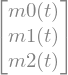

In [10]:
Ex = E(xt); Ex

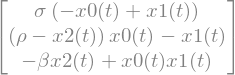

In [11]:
fx = sym.Matrix([p[0]*(xt[1] - xt[0]),
                 xt[0]*(p[1] - xt[2]) - xt[1],
                 xt[0]*xt[1] - p[2]*xt[2]], real=True); fx

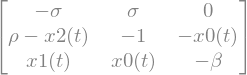

In [12]:
dfxdx = fx.jacobian(xt); dfxdx

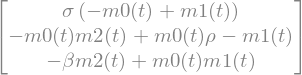

In [13]:
# E[f(x)]
Efx = E(fx).simplify(); Efx

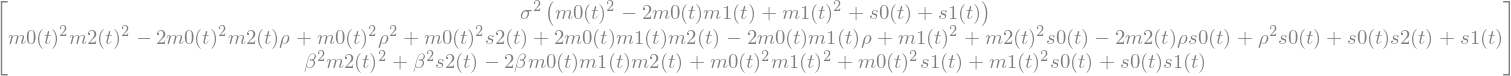

In [14]:
# E[f(x)^2]
Efx2 = E(fx.multiply_elementwise(fx)).simplify(); Efx2

In [15]:
# E[dfx/dx]
Edfxdx = E(dfxdx).diagonal().simplify(); Edfxdx

### Put all the $E_{sde}$ terms together.

These is given by the expression:

$E_{sde}(t) = \frac{1}{2} \sum_{i=1}^{D} \frac{1}{\sigma_{i}^2} \bigg( E[f_{i}^2]_{q_t} -2 E[f_{i}]_{q_t} \dot{m_i}(t) + \dot{m_i}^2(t) + \frac{(\dot{s_i}(t) - \sigma_{i}^2)^2}{4 s_{i}(t)} + (\sigma_{i}^2 - \dot{s_i}(t)) E\big[\frac{\partial f_i}{\partial x_i}\big]_{q_t}\bigg)$

Where $E[\cdot]_{q_t}$ is the expected value with respect to the Gaussian process.

In [16]:
# Stores the Esde_i.
Esde = []

# Get the expression for each dimension.
for i in range(D):
    
    # Display info.
    print(f"Estimating Esde_{i} ...")
    
    # Update the list.
    Esde.append(Efx2[i] - (2.0 * Efx[i] * dMt[i]) + dMt[i]**2 + (dSt[i] - sig[i])**2/(4.0 * Sfun[i]) + (sig[i] - dSt[i]) * Edfxdx[i])
    
# _end_for_

print("Done!")

Estimating Esde_0 ...
Estimating Esde_1 ...
Estimating Esde_2 ...
Done!


In [17]:
# Stores the parameterized Esde.
Esde_dk = []

# Count the succesful simplifications.
count_collect = 0

# Process each dimension separately.
for i in range(D):
    
    # Display info.
    print(f"Processing dimension: {i} ...")
    
    # Initialize temporary result.
    tmp_Ei = deepcopy(Esde[i])
    
    # Replace the mean functions.
    for j, mf_j in enumerate(Mfun):
        tmp_Ei = tmp_Ei.replace(mt[j], mf_j)
    # _end_for_
    
    # Replace the variance functions.
    for j, sf_j in enumerate(Sfun):
        tmp_Ei = tmp_Ei.replace(st[j], sf_j)
    # _end_for_
        
    # Atempt a "collect" simplification.
    collect_expr = tmp_Ei.collect(Mpar[i]).collect(Spar[i])
    
    # Make sure the expressions are equal.
    if tmp_Ei.equals(collect_expr):
        
        # Append the simplified expression.
        Esde_dk.append(collect_expr)
        
        # Increase the success counter.
        count_collect += 1
    else:
        
        # Append the non-simplified expression.
        Esde_dk.append(tmp_Ei)
    # _end_if_
    
# _end_for_

print(f"Done! (Count collect = {count_collect})")

Processing dimension: 0 ...
Processing dimension: 1 ...
Processing dimension: 2 ...
Done! (Count collect = 3)


In [ ]:
for l, Ei in enumerate(Esde_dk):
    
    print(f"Showing dimension {l}:\n")
    
    sym.pprint(Ei)
# _end_for_

print("Finished!")

### Compute the gradients.

In [18]:
# Define the gradient lists.
gradMp = []
gradSp = []

# Process each dimension separately.
for i in range(D):
    
    # Display info.
    print(f"Calculating gradients for dimension: {i} ...")
    
    # Reset the lists for each dimension.
    gradMi = []
    gradSi = []
    
    # Derivatives with respect to the mean parameters.
    for dim_k in Mpar:
        for mk in dim_k:
            gradMi.append(Esde_dk[i].diff(mk))
        # _end_for_
    # _end_for_
    
    # Derivatives with respect to the variance parameters.
    for dim_k in Spar:
        for sk in dim_k:
            gradSi.append(Esde_dk[i].diff(sk))
        # _end_for_
    # _end_for_
    
    # Update the lists.
    gradMp.append(gradMi)
    gradSp.append(gradSi)
    
# _end_for_

print("Done!")

Calculating gradients for dimension: 0 ...
Calculating gradients for dimension: 1 ...
Calculating gradients for dimension: 2 ...
Done!


In [19]:
# Define total gradients.
print(f"Initialize gradients with dimension: 0 ...")
tot_gradMp = deepcopy(gradMp[0])
tot_gradSp = deepcopy(gradSp[0])

# Process each dimension separately.
for i in range(1, D):
    
    # Display info.
    print(f"  > Adding gradients from dimension: {i} ...")
    
    # Add the dE/dmk.
    for grad_mi in gradMp:
        
        for j, dmk in enumerate(grad_mi):
            
            tot_gradMp[j] += dmk
        # _end_for_
        
    # _end_for_
    
    # Add the dE/dsk.
    for grad_si in gradSp:
        
        for j, dsk in enumerate(grad_si):
            
            tot_gradSp[j] += dsk
        # _end_for_
        
    # _end_for_
    
# _end_for_

print("Done!")

Initialize gradients with dimension: 0 ...
  > Adding gradients from dimension: 1 ...
  > Adding gradients from dimension: 2 ...
Done!


In [21]:
print(tot_gradSp[0])

2*rho**2*(-c1 + t)*(-c2 + t)/((c0 - c1)*(c0 - c2)) - 4*rho*(-c1 + t)*(-c2 + t)*(d2m0*(-h1 + t)*(-h2 + t)*(-h3 + t)/((h0 - h1)*(h0 - h2)*(h0 - h3)) + d2m1*(-h0 + t)*(-h2 + t)*(-h3 + t)/((-h0 + h1)*(h1 - h2)*(h1 - h3)) + d2m2*(-h0 + t)*(-h1 + t)*(-h3 + t)/((-h0 + h2)*(-h1 + h2)*(h2 - h3)) + d2m3*(-h0 + t)*(-h1 + t)*(-h2 + t)/((-h0 + h3)*(-h1 + h3)*(-h2 + h3)))/((c0 - c1)*(c0 - c2)) + 3*sigma**2*(-c1 + t)*(-c2 + t)/((c0 - c1)*(c0 - c2)) - 3*sigma*(-(-c1 + t)/((c0 - c1)*(c0 - c2)) - (-c2 + t)/((c0 - c1)*(c0 - c2))) + 3*(2*(-c1 + t)/((c0 - c1)*(c0 - c2)) + 2*(-c2 + t)/((c0 - c1)*(c0 - c2)))*(-Sig0 + d0s0*((-c1 + t)/((c0 - c1)*(c0 - c2)) + (-c2 + t)/((c0 - c1)*(c0 - c2))) + d0s1*((-c0 + t)/((-c0 + c1)*(c1 - c2)) + (-c2 + t)/((-c0 + c1)*(c1 - c2))) + d0s2*((-c0 + t)/((-c0 + c2)*(-c1 + c2)) + (-c1 + t)/((-c0 + c2)*(-c1 + c2))))/(4.0*d0s0*(-c1 + t)*(-c2 + t)/((c0 - c1)*(c0 - c2)) + 4.0*d0s1*(-c0 + t)*(-c2 + t)/((-c0 + c1)*(c1 - c2)) + 4.0*d0s2*(-c0 + t)*(-c1 + t)/((-c0 + c2)*(-c1 + c2))) + 2*(-

## End of notebook